link : https://drive.google.com/file/d/18_OoFVrqcv42W8qc_1a3eIJDfBILHAFI/view?usp=sharing

# Data collection and Pre-processing

In [11]:
import pandas as pd
df = pd.read_csv('data_news.csv')
print(df.head())

   category                                           headline  \
0  WELLNESS              143 Miles in 35 Days: Lessons Learned   
1  WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2  WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  WELLNESS                     Oh, What a Difference She Made   
4  WELLNESS                                   Green Superfoods   

                                               links  \
0  https://www.huffingtonpost.com/entry/running-l...   
1  https://www.huffingtonpost.com/entry/talking-t...   
2  https://www.huffingtonpost.com/entry/crenezuma...   
3  https://www.huffingtonpost.com/entry/meaningfu...   
4  https://www.huffingtonpost.com/entry/green-sup...   

                                   short_description  \
0  Resting is part of training. I've confirmed wh...   
1  Think of talking to yourself as a tool to coac...   
2  The clock is ticking for the United States to ...   
3  If you want to be busy, keep trying to 

In [12]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


Shape: (50000, 5)
Columns: ['category', 'headline', 'links', 'short_description', 'keywords']


In [13]:
df.isnull().sum()


category                0
headline                0
links                   0
short_description       0
keywords             2668
dtype: int64

In [14]:
df['category'].value_counts()


WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: category, dtype: int64

In [15]:
df = df.drop(columns=['links', 'keywords'])


In [16]:
# Combine headline and short description
df['text'] = df['headline'] + " " + df['short_description']


In [17]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)  # remove HTML
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leepa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Text Vectorization(Tfidf,BoW)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])


In [27]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(max_features=5000)
X_bow = bow.fit_transform(df['cleaned_text'])


In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['category'])  # Converts categories into numbers


In [31]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_map)


{'BUSINESS': 0, 'ENTERTAINMENT': 1, 'FOOD & DRINK': 2, 'PARENTING': 3, 'POLITICS': 4, 'SPORTS': 5, 'STYLE & BEAUTY': 6, 'TRAVEL': 7, 'WELLNESS': 8, 'WORLD NEWS': 9}


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Exploratory Data Analysis (EDA)

Bar Plot of News Categories

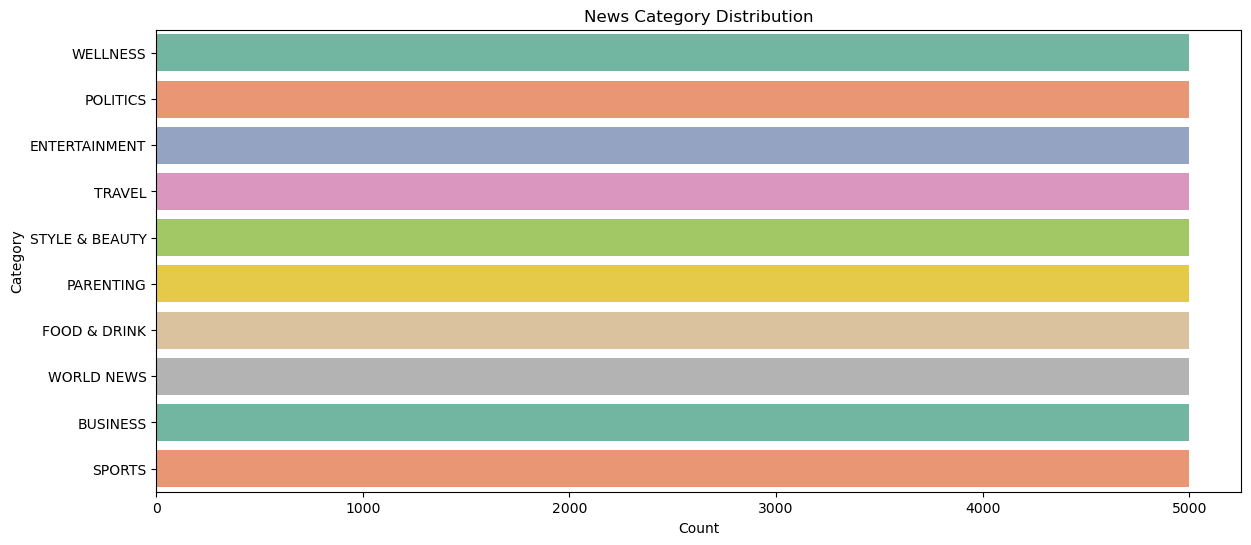

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.countplot(data=df, y='category', order=df['category'].value_counts().index, palette='Set2')
plt.title("News Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


Word Cloud per Category 

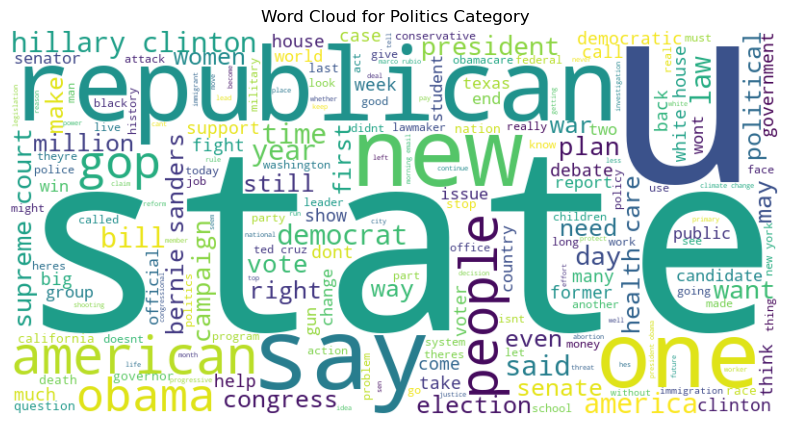

In [30]:
from wordcloud import WordCloud

# Example: Word cloud for POLITICS
politics_text = " ".join(df[df['category'] == 'POLITICS']['cleaned_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(politics_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Politics Category")
plt.show()


# Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define hyperparameter grid
param_grid = {'C': [0.1, 1, 10]}

# Apply GridSearchCV
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

# Predict using the best model
y_pred_lr = grid.predict(X_test)

# Print results
print("Best Parameters:", grid.best_params_)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))


Best Parameters: {'C': 1}
Logistic Regression Accuracy: 0.7905
                precision    recall  f1-score   support

      BUSINESS       0.72      0.78      0.75       955
 ENTERTAINMENT       0.77      0.77      0.77       985
  FOOD & DRINK       0.84      0.82      0.83      1021
     PARENTING       0.78      0.76      0.77      1030
      POLITICS       0.79      0.73      0.76      1034
        SPORTS       0.86      0.88      0.87       995
STYLE & BEAUTY       0.86      0.83      0.84       986
        TRAVEL       0.81      0.79      0.80      1008
      WELLNESS       0.71      0.76      0.73      1009
    WORLD NEWS       0.77      0.80      0.78       977

      accuracy                           0.79     10000
     macro avg       0.79      0.79      0.79     10000
  weighted avg       0.79      0.79      0.79     10000



# Naive Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

# Initialize the model
nb = MultinomialNB()

# Cross-validation scores on training data
cv_scores = cross_val_score(nb, X_train, y_train, cv=5, scoring='accuracy')

print("Naive Bayes CV Accuracy (mean):", cv_scores.mean())
print("All CV Scores:", cv_scores)

# Train on full training set
nb.fit(X_train, y_train)

# Predicting on test set
y_pred_nb = nb.predict(X_test)

# Evaluate
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))


Naive Bayes CV Accuracy (mean): 0.7743249999999999
All CV Scores: [0.772375 0.7775   0.77325  0.7765   0.772   ]
Naive Bayes Test Accuracy: 0.775
                precision    recall  f1-score   support

      BUSINESS       0.73      0.72      0.72       955
 ENTERTAINMENT       0.78      0.74      0.76       985
  FOOD & DRINK       0.83      0.84      0.83      1021
     PARENTING       0.68      0.74      0.71      1030
      POLITICS       0.78      0.72      0.75      1034
        SPORTS       0.87      0.86      0.86       995
STYLE & BEAUTY       0.84      0.82      0.83       986
        TRAVEL       0.78      0.80      0.79      1008
      WELLNESS       0.69      0.73      0.71      1009
    WORLD NEWS       0.78      0.79      0.78       977

      accuracy                           0.78     10000
     macro avg       0.78      0.78      0.78     10000
  weighted avg       0.78      0.78      0.78     10000



# Support Vector Machine (SVM)

In [42]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define hyperparameter grid
param_grid_svm = {'C': [0.1, 1, 10]}

# Grid search with 5-fold cross-validation
grid_svm = GridSearchCV(LinearSVC(max_iter=1000), param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train, y_train)

# Predict on test set
y_pred_svm = grid_svm.predict(X_test)

# Evaluate
print("Best SVM Params:", grid_svm.best_params_)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))


SVM Accuracy: 0.7839
                precision    recall  f1-score   support

      BUSINESS       0.72      0.78      0.75       955
 ENTERTAINMENT       0.77      0.75      0.76       985
  FOOD & DRINK       0.83      0.84      0.83      1021
     PARENTING       0.76      0.75      0.75      1030
      POLITICS       0.78      0.72      0.74      1034
        SPORTS       0.86      0.91      0.88       995
STYLE & BEAUTY       0.84      0.84      0.84       986
        TRAVEL       0.79      0.77      0.78      1008
      WELLNESS       0.72      0.72      0.72      1009
    WORLD NEWS       0.76      0.78      0.77       977

      accuracy                           0.78     10000
     macro avg       0.78      0.78      0.78     10000
  weighted avg       0.78      0.78      0.78     10000

Best SVM Params: {'C': 0.1}
SVM Test Accuracy: 0.7915
                precision    recall  f1-score   support

      BUSINESS       0.73      0.78      0.76       955
 ENTERTAINMENT       0.79

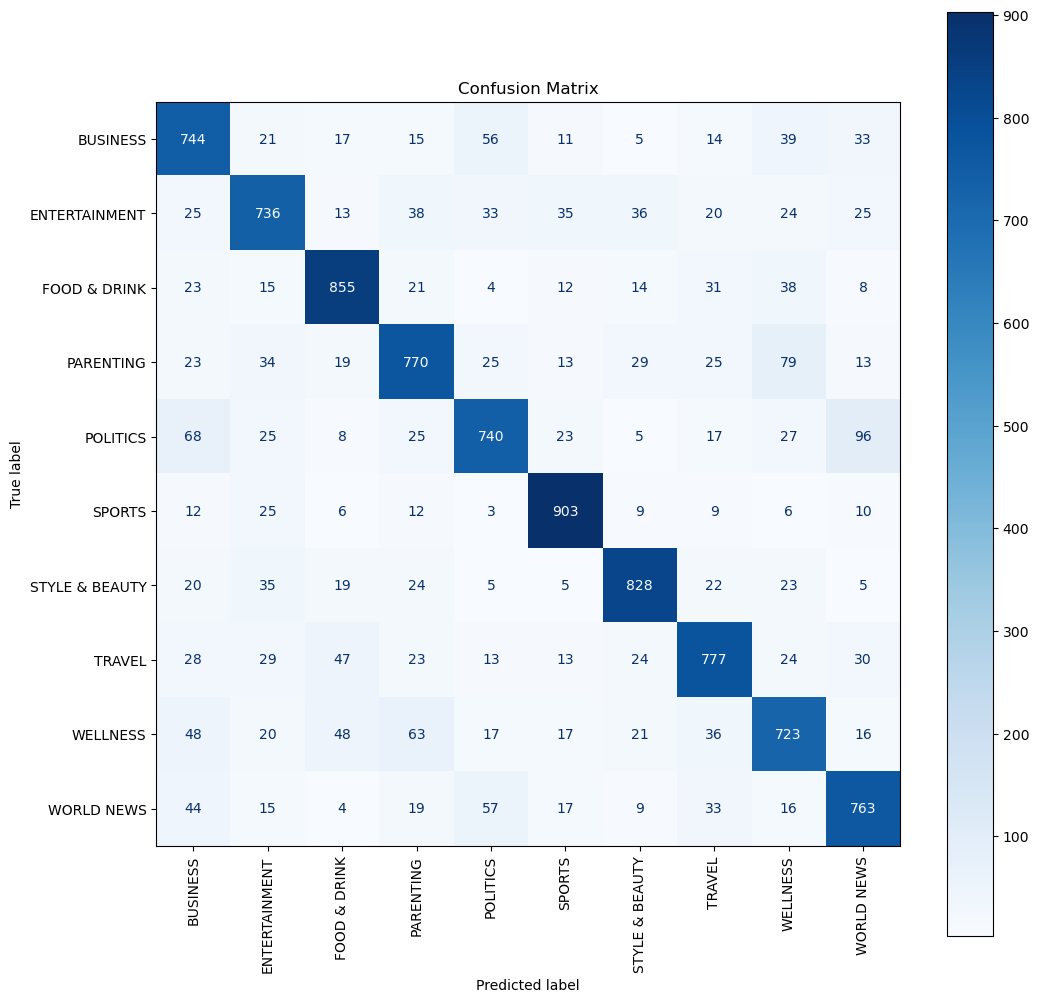

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use predictions from your best model
cm = confusion_matrix(y_test, y_pred_svm)  # or y_pred_lr, etc.

# Create confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot correctly
fig, ax = plt.subplots(figsize=(12, 12))  # manually set figure size
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')  # now this works
plt.title("Confusion Matrix")
plt.show()

